In [147]:
import cv2
import os
import random
import zipfile
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [148]:
def showImage(img, shape, label, cmap='gray'):
    plt.subplot(3, 6, 1)
    plt.title(label)
    plt.imshow(img.reshape(shape), cmap=cmap)
    plt.subplots_adjust(right=1.2, top=1.2)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',
                    top='off', right='off', left='off', which='both')
    plt.show()

In [149]:


def load_dataset(path, image_size):

    images = []
    labels = []

    for label_name in os.listdir(path):
        target_path = os.path.join(path, label_name)

        if len([f for f in os.listdir(target_path)]) > 1:
            for filename in os.listdir(target_path):
                file_path = os.path.join(target_path, filename)
                # image = Image.open(file_path)
                image = cv2.imread(file_path)
                image = cv2.resize(image, image_size)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                images.append(image)
                labels.append(label_name)

    return images, labels


path = 'cropped_dataset'
image_size = (100, 100)
dataset = load_dataset(path, image_size)

print(
    f"dataset length = {len(dataset[0])}, image shape = {dataset[0][0].shape}, first label = {dataset[1][0]}")

dataset length = 529, image shape = (100, 100), first label = Abdissa Degefu


In [150]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

# Assuming you have a dataset in the form of (images, labels)
# Replace this with your actual dataset loading code
dataset = load_dataset(path, image_size)
images, labels = dataset

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Shuffle the data
# np.random.seed(0)
# shuffle_indices = np.random.permutation(len(images))
# images = images[shuffle_indices]
# labels = labels[shuffle_indices]

# Categorical label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# One-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
encoded_labels_onehot = onehot_encoder.fit_transform(
    encoded_labels.reshape(-1, 1))

# Store the one-hot encoded labels and mapping in the dataset
label_mapping = dict(zip(label_encoder.classes_, encoded_labels_onehot.T))
new_dataset = (images.tolist(), encoded_labels_onehot.tolist(), label_mapping)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    images, encoded_labels_onehot, test_size=0.2, random_state=42, stratify=encoded_labels_onehot)

# Decode the one-hot encoded labels back to their original form
training_labels = label_encoder.inverse_transform(np.argmax(y_train, axis=1))
testing_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

print("Original Labels in Training Set:")
print(training_labels[:5])
print(f"Training Set Length: {len(y_train)}")
print("Original Labels in Testing Set:")
print(testing_labels[:5])
print(f"Testing Set Length: {len(y_test)}")

# Print the label mapping
# print("Label Mapping:", label_mapping)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Original Labels in Training Set:
['Abraham Wendmeneh' 'Mariam Yohannes' 'Fasika_Fikadu' 'Betelhem Yimam'
 'Bethelhem Yemane']
Training Set Length: 423
Original Labels in Testing Set:
['Gelila Tefera' 'Fasika_Fikadu' 'Leul Wujira' 'Yonas Engedu'
 'Yanet Mekuria']
Testing Set Length: 106


In [151]:
faces = []
for face in X_train:
    faces.append(face.flatten())

faces = np.array(faces)
faces.shape

(423, 10000)

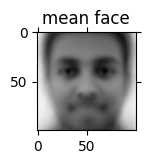

Shape of the covariance matrix : (423, 423)
Shape of selected eigenvectors : (423, 423)
Shape of the eigenSpace : (423, 10000)
Shape of the projected dataset : (423, 423)


In [152]:


# zero centering the training set
meanFace = faces.mean(axis=0)
faces = faces - meanFace
showImage(meanFace, image_size, "mean face")

# finding the covariance of the training faces
covariance = np.cov(faces)
print(f'Shape of the covariance matrix : {covariance.shape}')

# performing general eigne decompsition on the covariance matrix
decompostion = np.linalg.svd(covariance)
U = decompostion[0]

# selecting k eigenvectors , where k = m and m is the number of images in the training set inorder to make our training set singular
seletedEigen = U[:, : faces.shape[0]]
print(f'Shape of selected eigenvectors : {seletedEigen.shape}')

# obtaining the eigenspace from the selected eigenvectors
eigenSpace = seletedEigen.T.dot(faces)
print(f'Shape of the eigenSpace : {eigenSpace.shape}')

# project the dataset onto this new eigen space
faces = faces.dot(eigenSpace.T)
print(f'Shape of the projected dataset : {faces.shape}')

Perform LDA


compute mean of each class and put them in a list. do the same for the mean of all faces


In [153]:
# variable for holding the class mean vectors
meanVectors = []

# variable for holding the mean of all faces
globalMean = faces.mean(axis=0)

for trainig_label in set(training_labels):
    classMean = []
    class_indices = [training_labels.tolist().index(label)
                     for label in training_labels.tolist()]

    # same_class_pics = []
    for index in class_indices:
        # same_class_pics.append(faces[index])
        classMean.append(faces[index])
    classMean = np.array(classMean)
    classMean = classMean.mean(axis=0)
    meanVectors.append(classMean)

meanVectors = np.array(meanVectors)


print(f'Shape of mean vectors : {meanVectors.shape}')
print(f'Shpae of the global mean : {globalMean.shape}')

Shape of mean vectors : (50, 423)
Shpae of the global mean : (423,)


compute within class scatter


In [154]:
# matrix used for storing within class scatter
s_w = np.zeros(faces.shape)

classNames = set(training_labels)

class_indices = [training_labels.tolist().index(label)
                 for label in training_labels.tolist()]
for className in classNames:
    indexOfMean = list(classNames).index(className)
    classMean = meanVectors[indexOfMean]

    # for imageIndex in imageClasses[imageClass]:
    for imageIndex in class_indices:
        if (training_labels[imageIndex] == className):
            image = faces[imageIndex]

            # subtract the class mean from the image
            image = image - classMean

            # get the scatter matrix
            image = image.reshape(-1, 1)  # convert to column vector
            scatterMatrix = np.dot(image, image.T)

            # add to the within scatter matrix
            s_w += scatterMatrix

print(f'Within class scatter matrix shape : {s_w.shape}')

Within class scatter matrix shape : (423, 423)


compute between class scatter matrix


In [155]:
# matrix used for storing between class scatter
s_b = []

classNames = set(training_labels)

# subtract the global mean from the class means
meanVectors = meanVectors - globalMean

for className in classNames:
    # the number of images in a given class
    classcount = Counter(list(classNames))
    num = classcount[className]

    indexOfMean = list(classNames).index(className)
    classMean = meanVectors[indexOfMean]

    # get the scatter matrix
    classMean = classMean.reshape(-1, 1)
    scatterMatrix = num * classMean.dot(classMean.T)

    # add to the between scatter matrix
    if len(s_b) == 0:
        s_b = np.array(scatterMatrix)
    else:
        s_b += scatterMatrix

print(f'Between class scatter matrix shape : {s_b.shape}')

Between class scatter matrix shape : (423, 423)


Solve the generalized eigenvalue problem for the matrix s_w.inverse().dot(s_b)


In [156]:
# matrix for holding s_w^-1 * s_b
problem = np.linalg.inv(s_w.T).dot(s_b.T)

# eigenvectors and eigenvalues of the problem
decompostion = np.linalg.svd(problem)
U = decompostion[0]  # eigen vectors
S = decompostion[1]  # eigen values

print(f'Shape of the decomposed vectors : {U.shape}')

# put the eigenvectors and eigenvalues in pair : (eigenvalue , eigenvector)
eigenPairs = [(np.abs(S[i]), U[:, i]) for i in range(len(S))]

# sort the eigenpairs
eigenPairs.sort(key=lambda element: element[0], reverse=True)

Shape of the decomposed vectors : (423, 423)


select k eigenvectors that describe 99% of the variance


In [157]:
# sum of the total eigen values
total = np.array([pair[0] for pair in eigenPairs])
total = total.sum()


# current sum of the eigenvalues
currentSum = 0

# variable to count index
index = 0

for eigenPair in eigenPairs:
    currentEigen = eigenPair[0]
    currentSum += currentEigen
    if currentSum / total >= 0.99:
        print(f'chose {index + 1} from {len(eigenPairs)}')
        break
    index += 1

# select the importat eigenvector
selectedVectors = np.array([i[1] for i in eigenPairs])

print(f'Shape of selected K components : {selectedVectors.shape}')

chose 1 from 423
Shape of selected K components : (423, 423)


project given data to the selected vectors


In [158]:
ldaProjection = faces.dot(selectedVectors.T)
print(f'Shape of LDA projection : {ldaProjection.shape}')

Shape of LDA projection : (423, 423)


project training faces onto the eigenspace and then to the lda projection of them


In [159]:
testingFaces = []
for face in X_test:
    testingFaces.append(face.flatten())
testingFaces = np.array(testingFaces)
# zero centering the testing faces
testingFaces = testingFaces - meanFace

# projecting the testing faces using pca
testingFaces = testingFaces.dot(eigenSpace.T)
print(f'Shape of testing faces in pca projection : {testingFaces.shape}')

# now projecting the faces using lda
testingFaces = testingFaces.dot(selectedVectors.T)
print(f'Shape of testing faces in lda projection : {testingFaces.shape} ')

Shape of testing faces in pca projection : (106, 423)
Shape of testing faces in lda projection : (106, 423) 


use nearest neighbor classifier to determine which faces resemble which class


In [160]:
from collections import Counter

testIndex = 0
correct = 0

for testFace in testingFaces:
    # calculating the distance of the projected test face to all of the training faces and getting the shortest
    difference = ldaProjection - testFace
    eucleadeanDistance = np.linalg.norm(difference, axis=1)
    maxDist = eucleadeanDistance.max()
    eucleadeanDistance = eucleadeanDistance.tolist()

    # arrange the distances in increasing order
    arrangedDistance = [*eucleadeanDistance]
    arrangedDistance.sort()

    # selected distance
    neighbours = 1
    selected = arrangedDistance[: neighbours]
    selectedLables = [training_labels[eucleadeanDistance.index(
        neighbour)] for neighbour in selected]

    # select the majority
    labelCounts = Counter(selectedLables)
    predictedName = max(labelCounts, key=labelCounts.get)

    # get the actual name
    actualName = testing_labels[testIndex]

    if predictedName == actualName:
        correct += 1
    testIndex += 1


print(f'Accuracy : {correct / (testIndex + 1)}')

Accuracy : 0.897196261682243


In [161]:
# Load the pre-trained face detector
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

testset = []

for filename in os.listdir('TestImages'):
    if filename.endswith(('.jpg', '.jpeg', '.png')):

        image_path = os.path.join(
            'TestImages', filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image
        faces = face_cascade.detectMultiScale(
            gray, scaleFactor=1.3, minNeighbors=5)

        # Process each detected face
        for i, (x, y, w, h) in enumerate(faces):
            face_roi = image[y:y+h, x:x+w]
            face_roi = cv2.resize(cv2.cvtColor(
                face_roi, cv2.COLOR_BGR2GRAY), image_size)
            testset.append(face_roi.flatten())
            # showImage(face_roi, face_roi.shape, label="face")
            # Save each cropped face with a unique filename
testset = np.array(testset)

Husen Yusuf


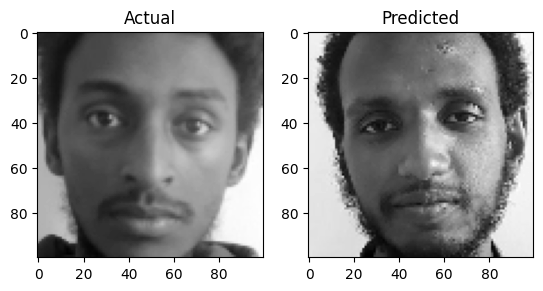

Metsakal Zeleke


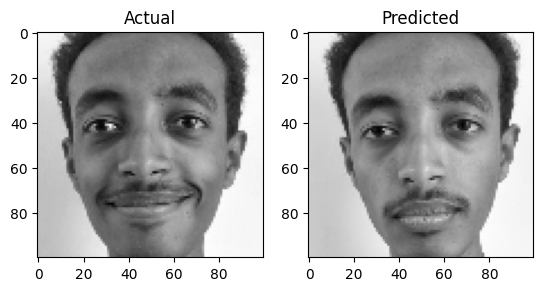

Yohannes Dessie


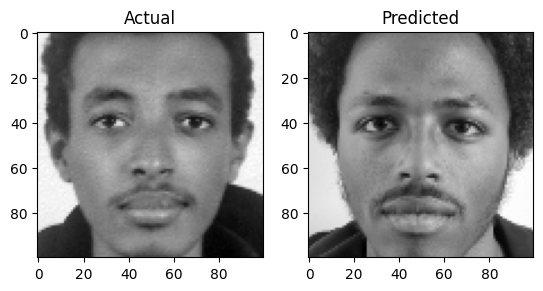

Milka Fasika


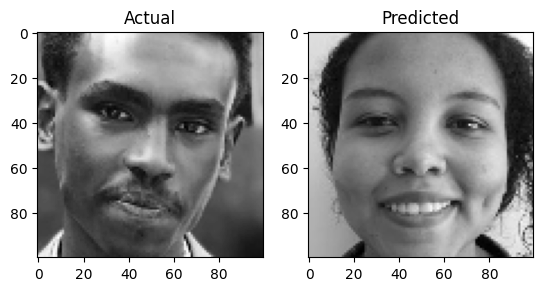

In [162]:
from collections import Counter

testIndex = 0
correct = 0
# zero centering the testing faces
testingFaces = testset - meanFace

# projecting the testing faces using pca
testingFaces = testingFaces.dot(eigenSpace.T)
# print(f'Shape of testing faces in pca projection : {testingFaces.shape}')

# now projecting the faces using lda
testingFaces = testingFaces.dot(selectedVectors.T)
# print(f'Shape of testing faces in lda projection : {testingFaces.shape} ')

for i, testFace in enumerate(testingFaces):
    # calculating the distance of the projected test face to all of the training faces and getting the shortest
    difference = ldaProjection - testFace
    eucleadeanDistance = np.linalg.norm(difference, axis=1)
    maxDist = eucleadeanDistance.max()
    eucleadeanDistance = eucleadeanDistance.tolist()

    # arrange the distances in increasing order
    arrangedDistance = [*eucleadeanDistance]
    arrangedDistance.sort()

    # selected distance
    neighbours = 1
    selected = arrangedDistance[: neighbours]
    selectedLables = [training_labels[eucleadeanDistance.index(
        neighbour)] for neighbour in selected]

    # select the majority
    labelCounts = Counter(selectedLables)
    predictedName = max(labelCounts, key=labelCounts.get)
    print(predictedName)
    predictedFace = X_train[training_labels.tolist().index(predictedName)]

    # get the actual name
    plt.subplot(1, 2, 1)
    plt.imshow(testset[i].reshape(image_size), cmap='gray')
    plt.title('Actual')

    plt.subplot(1, 2, 2)
    plt.imshow(predictedFace.reshape(image_size), cmap='gray')
    plt.title('Predicted')

    plt.show()


# print(f'Accuracy : {correct / (testIndex + 1)}')